### Planetary Orbit with Adaptive Runge-Kutta integrator


a) **Mathematical Theorey**

Runge-Kutta method implies an numerical approximation of a time dependant function at $\Delta t = h$ later if given the current value:
$$
y(x+h) = y(x) + {h\over 6}\left(f_0 + 2f_1 + 2f_2 +f_3\right).
$$
where:
$$
f_0 = f(x,y)
$$
$$
f_1 = f(x+h/2, y(x) + {h\over 2}f_0)
$$
$$
f_2 = f(x+h/2, y(x) + {h\over 2}f_1)
$$
$$
f_3 = f(x+h, y(x) + h f_2)
$$
An Uniform stepsize method would assume constant $\Delta t$ over time. But an Adaptive stepsize method would need changing $\Delta t$ over time:

For a certain constant $\delta$, if:
$$
f(x + H) - f(x+\frac{H}{2}, x+ H) < \delta
$$
Take the step $x+H$ and increase the step size: $H_{i+1} = 2H_{i}$. Otherwise, decrease the step size: $H_{i+1} = \frac{H_{i}}{2}$.



b)**Code Implementation and Results**


At around 350 steps in both method, the uniform method ending point has a large error with where it starts in the orbit, while the adaptive method gives a much better results.

Another intersting thing is if to visualize the stepsize as the position in orbit, the results shows that stpesize is related to Kepler's Law(function of orbital motion). The red dot shown in the figure is the centre of the orbit, according to Kepler's 2nd, planet will gain faster velocity when approching perihelion, changing in velocity is also larger(due to change in direction), thus the stepsize should be smaller (decrease) to compensate the larger error if taking uniform stepsize. Otherwise, when approaching aphelion, planet slows down, stepsize increases.

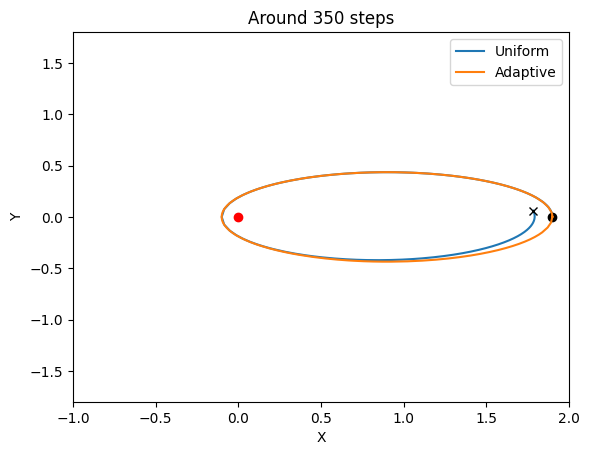

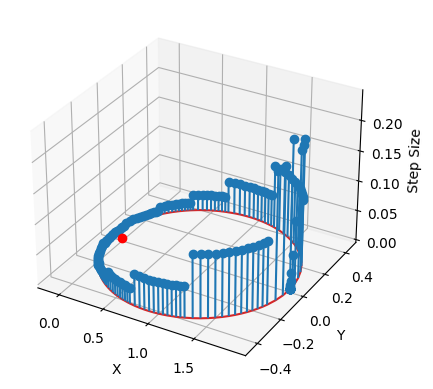

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import init_printing

# Kepler orbital equation
def derivs_orbit(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

# RK in a single step
def rk4_single_step(dt, x0, derivs):
    f = derivs(0, x0)
    f1 = derivs(dt/2, x0 + f*dt/2)
    f2 = derivs(dt/2, x0 + f1*dt/2)
    f3 = derivs(dt, x0 + f2*dt)
    x = x0 + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x

# RK with uniform stepsize 
def rk4(nsteps, dt, x0, derivs):
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    for i in range(1,nsteps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)
        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x


def rk4_adaptive_stepsize(accuracy, end, x0, derivs):
    # set a starting stepsize, equal to the error tolerance
    # and a list to store the history of step size 
    dt = accuracy
    dt_list = np.zeros(1)

    # Similarly, a set of velocity and position history
    x_hist = np.zeros((1,len(x0)))
    x_hist[0] = x0

    for i in range(10000): # Give it a large number so it keep looping before break

        # perpose a try of stepping 
        x_try = rk4_single_step(dt, x_hist[0], derivs= derivs) 
        x_tryhalf = rk4_single_step(dt/2, x_hist[0], derivs= derivs)
        x_tryhalf2 = rk4_single_step(dt/2, x_tryhalf, derivs= derivs) 
        err = x_try - x_tryhalf2

        # Comparing the error to accuracy tolerance
        if np.sqrt(err[0]**2 + err[1]**2) <= accuracy: 
            x_hist = np.insert(x_hist, 0, x_try, axis=0)
            dt_list = np.insert(dt_list, 0, dt)
            dt = 2*dt_list[0]
        else:
            dt = dt/2

        # Break the loop so that toatal dt is 2pi
        if dt + np.sum(dt_list) >= end:
            dt_final = end - sum(dt_list)
            x_final_try = rk4_single_step(dt_final, x_hist[0], derivs= derivs)
            x_hist = np.insert(x_hist, 0, x_final_try , axis=0)
            dt_list = np.insert(dt_list, 0, dt_final)
            break

    # Again, this is a thing with my style of coding
    # I don't like list and append when dealling with vectors,
    # I will insert the new number in front of old ones, 
    # thus, when return, it needs to be inverted
    dt_hist = dt_list
    return x_hist[::-1], dt_hist[::-1]



# set the constant and initial condition for eliptical orbit
eccen = 0.9
x_start = np.array((1 + eccen, 0, 0, np.sqrt(2/(1+eccen) - 1)))


# test run sample orbit of uniform and adaptive step:
uniform_results = rk4(350, 2*np.pi/350, x_start, derivs_orbit)
adaptive_results, stepsize = rk4_adaptive_stepsize(accuracy = 1e-7, end = 2* np.pi, x0=x_start, derivs= derivs_orbit)


# Visualization

# 2-D plane orbit of both method:
plt.plot(uniform_results[:,0], uniform_results[:,1], label="Uniform")
plt.plot(adaptive_results[0,0],adaptive_results[0,1],'ko')
plt.plot(uniform_results[-1,0],uniform_results[-1,1],'kx')
plt.plot(adaptive_results[:,0], adaptive_results[:,1], label="Adaptive")
plt.plot(0, 0, "ro")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-1, 2)
plt.ylim(-1.8, 1.8)
plt.title("Around 350 steps")
plt.legend()
plt.show()


# 3D graph showing the step size change in adaptive step size method
ax = plt.figure().add_subplot(projection='3d')
ax.stem(adaptive_results[:,0], adaptive_results[:,1], stepsize)
ax.set(xlabel="X", ylabel="Y", zlabel='Step Size')
ax.plot(0,0,0,"ro")
plt.show()



c) **Error Analysis**

A comparison between adaptive step size and uniform stepsize of Runge -Kutta method shown below demonstrate a differnce in decrease of error with the number of timesteps. In a **long-log** plot, both of them shows a linear relation with almost identitical slopes (ie. very similar rate of decending). 

However, adaptive steps give the error a much smaller starting point. Which means that for same amount of steps (for example $\approx$ 350 steps, shown in graph below), adaptive stepsize method is much more accurate than taking uniform step size; more sepcifically, the error is **5 orders of magnitude smaller** than the uniform stepsize method ($\sim 10^{-5}$) This result will explain what I mentioned in previous part. When apative stepsize method being incredibly arrcurate (error $\sim 10^{-6}$), the uniform stepsize is doing a bad job (error $\sim 10\%$)

This also inplies that, for a certain desired accuracy of the result, adpative stepsize method would require much less number of step, hence being much more efficient. For example, if to demand an accuracy of $10^{-6}$, (shown below, esitmated by linear interpolation):
$$
\frac{N_{uniform}}{N_{adaptive}} = \frac{4300}{380} = 11 
$$
Taking adaptive stepsize will be about **10 times faster** than taking uniform steps.

In [4]:
# Uniform stepsize:
step_list = np.logspace(2, 5, 30, dtype=int)    # from 100 to 100000
x_uni_err = []
x_uni_step = []
for nsteps in step_list:

    dt = 2 * np.pi / (nsteps-1)
    x_uni = rk4(nsteps, dt, x_start, derivs_orbit)
    
    diserr = np.sqrt((x_uni[0,0] - x_uni[-1, 0])**2 + (x_uni[0,1] - x_uni[-1,1])**2)
    steps = len(x_uni)
    x_uni_step.append(steps)
    x_uni_err.append(diserr)



# Adaptive stepsize:
accuracy_tolerance = np.logspace(-4, -14.5, 30)    # from small number to round-off error
x_adap_err = []
x_adap_step = []
for tolerance in accuracy_tolerance:
    x_adap,_ = rk4_adaptive_stepsize(accuracy = tolerance, end = 2* np.pi, x0=x_start, derivs= derivs_orbit)
    
    diserr = np.sqrt((x_adap[0,0] - x_adap[-1, 0])**2 + (x_adap[0,1] - x_adap[-1,1])**2)
    steps = len(x_adap)
    x_adap_step.append(steps)
    x_adap_err.append(diserr)


# These numbers of "steps" and "Accuracy tolerance" are pre-dicided 
# depends on the results of test-runs I have done 

Uniform stepsize method requires:  4322.911641772606
Adaptive stepsize method requires:  384.54983394688554


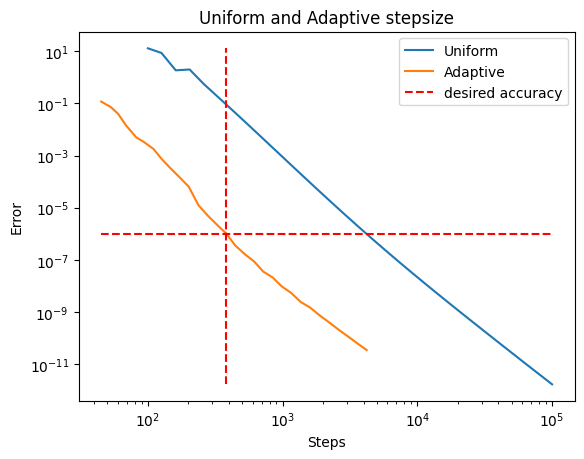

In [5]:
# Make interpolation estimating numbers of steps needed to achieve certain accuracy
# This is a better way to determine steps number, which I don't have to run functions again
# instead of run a for loop and breaks at the desired accuracy
# Although the best way is fitting lines of the loglog plot and then determine the value

from IPython.display import display, Latex

desired_error = 1e-6
unistep = np.interp(desired_error, x_uni_err[::-1],x_uni_step[::-1])
adaptsteps = np.interp(desired_error, x_adap_err[::-1],x_adap_step[::-1])
print ("Uniform stepsize method requires: ", unistep)
print ("Adaptive stepsize method requires: ", adaptsteps)

plt.loglog(x_uni_step, x_uni_err, label="Uniform")
plt.loglog(x_adap_step, x_adap_err, label="Adaptive")
plt.hlines(y= 1e-6, xmin=min(x_adap_step), xmax=max(x_uni_step), colors="red",linestyles="dashed", label="desired accuracy")
plt.vlines(x = 380, ymin= min(x_uni_err), ymax= max(x_uni_err), colors="red",linestyles="dashed")
plt.xlabel("Steps")
plt.ylabel("Error")
plt.title("Uniform and Adaptive stepsize")
plt.legend()
plt.show()